# Handwritten Lower and Upper case letter recognition with Keras CNN

In [1]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from mnist import MNIST
import matplotlib.pyplot as plt

In [1]:
#run once to download data
#Source for dataset: https://www.nist.gov/node/1298471/emnist-dataset

# !wget https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
# !unzip gzip.zip #use Expand-Archive -Path "your_archive.zip" -DestinationPath "destination_folder" in windows
# !rm gzip.zip #use del in windows

# Preparing data set

In [2]:
# load the entire EMNIST dataset as numpy arrays
emnist_data = MNIST(path='gzip', return_type='numpy')
emnist_data.select_emnist('byclass')
x_train, y_train = emnist_data.load_training()
x_test, y_test = emnist_data.load_testing()

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((697932, 784), (697932,), (116323, 784), (116323,))

In [8]:
# filter only the letters and not the digits
labels = np.array(range(10, 62))
train_mask = np.isin(y_train, labels)
test_mask = np.isin(y_test, labels)

train_images = x_train[train_mask]
train_labels = y_train[train_mask]

test_images = x_test[test_mask]
test_labels = y_test[test_mask]

In [9]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((352897, 784), (352897,), (58405, 784), (58405,))

In [10]:
img_side = 28
# Reshape tensors to [n, y, x, 1] and normalize the pixel values between [0, 1]
x_train = x_train.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0

x_train.shape, x_test.shape

((697932, 28, 28, 1), (116323, 28, 28, 1))

In [11]:
# get number of classes
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

input_shape = (img_side, img_side, 1)

# weight the classes (to combat the imbalance)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)))

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [12]:
#Create model
kernel_size = (5, 5)
def createmodel():
    return Sequential([
        Convolution2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.4),
        Convolution2D(32, kernel_size=kernel_size, padding='same', activation= 'relu'), #strides=2,
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.4),
        Convolution2D(64, kernel_size=kernel_size, padding='same', activation= 'relu'),
        MaxPooling2D(pool_size =(2,2)),
        BatchNormalization(),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax'),
    ])

In [13]:
# setting up model to run on cpu, or gpu when avaiable
model = createmodel()
model.compile(loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0

In [14]:
#Train model
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True)

In [15]:
model.fit(x_train, y_train,
          #class_weight=class_weights,
          batch_size=10000,
          epochs=200,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test),
          callbacks=[es])

Epoch 1/200
70/70 [==============================] - 83s 1s/step - loss: 1.7355 - accuracy: 0.5546 - val_loss: 4.4082 - val_accuracy: 0.0907
Epoch 2/200
70/70 [==============================] - 81s 1s/step - loss: 0.8015 - accuracy: 0.7459 - val_loss: 5.5885 - val_accuracy: 0.0198
Epoch 3/200
70/70 [==============================] - 82s 1s/step - loss: 0.6588 - accuracy: 0.7837 - val_loss: 5.5171 - val_accuracy: 0.0163
Epoch 4/200
70/70 [==============================] - 82s 1s/step - loss: 0.5921 - accuracy: 0.8020 - val_loss: 4.6505 - val_accuracy: 0.0716
Epoch 5/200
70/70 [==============================] - 83s 1s/step - loss: 0.5549 - accuracy: 0.8125 - val_loss: 2.5618 - val_accuracy: 0.2805
Epoch 6/200
70/70 [==============================] - 81s 1s/step - loss: 0.5304 - accuracy: 0.8195 - val_loss: 1.2092 - val_accuracy: 0.6211
Epoch 7/200
70/70 [==============================] - 81s 1s/step - loss: 0.5098 - accuracy: 0.8252 - val_loss: 0.6712 - val_accuracy: 0.7690
Epoch 8/200
7

In [16]:
#Evaluate model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3636/3636 [==============================] - 16s 4ms/step - loss: 0.3451 - accuracy: 0.8701
Test loss: 0.3451273739337921
Test accuracy: 0.8700773119926453


In [17]:
y_pred = model.predict(x_test)

3636/3636 [==============================] - 15s 4ms/step


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.metrics import confusion_matrix

<Axes: >

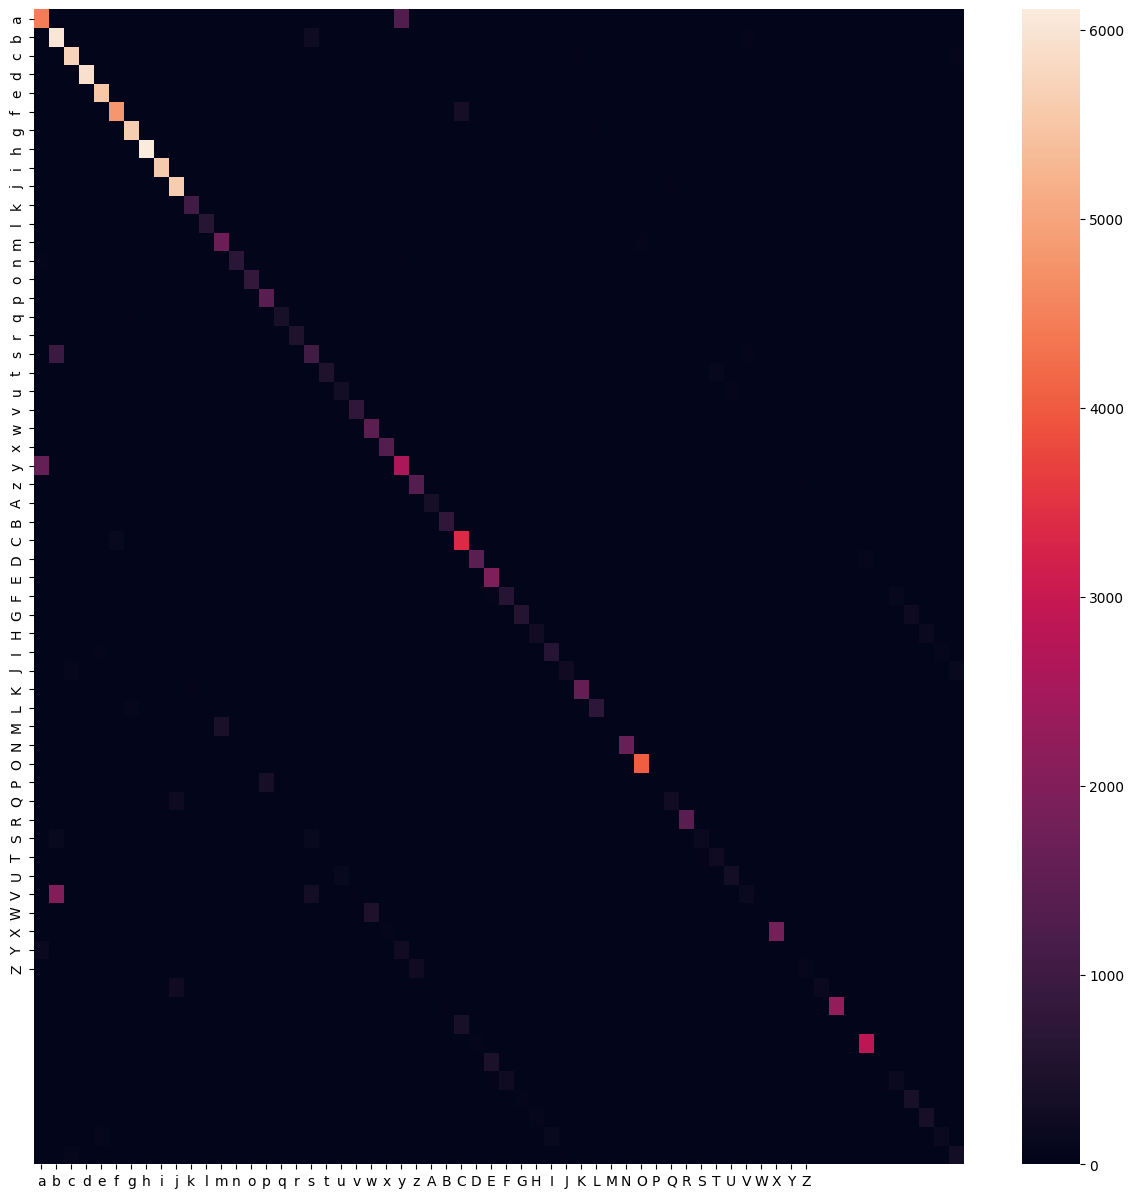

In [22]:
labels = string.ascii_letters
plt.subplots(figsize=(15,15))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), xticklabels=labels, yticklabels=labels)

In [25]:
#Save model
model.save("letters_only_cnn.h5")

c:\Users\ayus3\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
